### skleanとかそういう機械学習ライブラリを使わずに、MLPしてみたい

## MLP
使うデータは、よくあるirisデータ

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import pandas as pd
import urllib.request 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
url = "https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/iris.txt"
urllib.request.urlretrieve(url, 'iris.txt') 

('iris.txt', <http.client.HTTPMessage at 0x11c23cd10>)

In [5]:
df = pd.read_csv("iris.txt", sep="\t", index_col=0)
print(df.shape) # 何行何列か確認する
df.head() # 先頭五行の内容を確認する

(150, 5)


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,0
2,4.9,3.0,1.4,0.2,0
3,4.7,3.2,1.3,0.2,0
4,4.6,3.1,1.5,0.2,0
5,5.0,3.6,1.4,0.2,0


### よくある手法① scikit-lean

In [6]:
X = np.array(df.iloc[:, :4].values) 
Y = np.array(df.iloc[:, 4])

In [8]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=10000)
clf.fit(X, Y)
clf.score(X, Y)　#accuracy score

0.9733333333333334

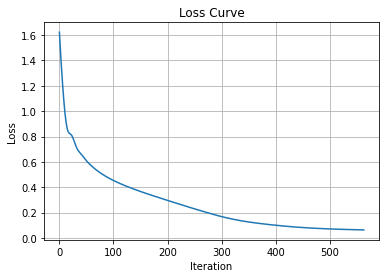

In [10]:
#ロス（教師データと予測データとのズレ）が収束するか調べる
plt.title("Loss Curve")
plt.plot(clf.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [11]:
#作成したモデルのパラメータ
clf.get_params

<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)>

In [12]:
#予測結果
clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [13]:
#それぞれの予測に対する自信のほど
pd.DataFrame(clf.predict_proba(X)).head()

,0,1,2
0,0.999230,0.000770,9.518924e-15
1,0.997262,0.002738,3.129361e-13
2,0.998635,0.001365,9.220638e-14
3,0.996265,0.003735,1.096605e-12
4,0.999351,0.000649,7.638195e-15


### scikit-learnを使わない方法

In [14]:
def one_hot_vectors(V): # one hot vector に変換する
    T = pd.DataFrame([])
    T[0] = [1 if v == 0 else 0 for v in V]
    T[1] = [1 if v == 1 else 0 for v in V]
    T[2] = [1 if v == 2 else 0 for v in V]
    return np.array(T)

In [15]:
X = np.array(df.iloc[:, :4].values)
Y = one_hot_vectors(df.iloc[:, 4])

自前MLPの作成

In [17]:
class MyMLP:
    def __init__(self, input_layer_size, hidden_layer_size, output_layer_size):
        init_weight = 0.01 # ランダムな初期値に対してちょっとバラツキを控えめにする

        # 隠れ層の重み行列W1とバイアスb1にランダムな初期値を与える
        self.W1 = init_weight * np.random.randn(input_layer_size, hidden_layer_size)
        self.b1 = np.zeros(hidden_layer_size)
        self.a1 = [] # 隠れ層が保持する値（シグモイド関数による変換前）
        self.z1 = [] # 隠れ層が保持する値（シグモイド関数による変換後）

        # 出力層の重み行列W2とバイアスb2にランダムな初期値を与える
        self.W2 = init_weight * np.random.randn(hidden_layer_size, output_layer_size)
        self.b2 = np.zeros(output_layer_size)
        self.a2 = [] # 出力層が保持する値（ソフトマックス関数による変換前）
        self.z2 = [] # 出力層が保持する値（ソフトマックス関数による変換後）

        self.loss_ = -1 # 誤差
        self.loss_curve_ = [] # 誤差の履歴

        print("W1.shape=", self.W1.shape)
        print("b1.shape=", self.b1.shape)
        print("W2.shape=", self.W2.shape)
        print("b2.shape=", self.b2.shape)

    def forward_propagation(self, x): # 前向き計算
        self.a1 = np.dot(x, self.W1) + self.b1 # 入力層からの入力と重み行列との線形和＋バイアス
        self.z1 = sigmoid(self.a1) # シグモイド関数で変換して隠れ層からの出力とする
        self.a2 = np.dot(self.z1, self.W2) + self.b2 # 隠れ層からの入力と重み行列との線形和＋バイアス
        self.z2 = softmax(self.a2) # ソフトマックス関数で変換して出力層からの出力とする
        return self.z2 # 出力層からの出力を予測結果とする

    def backward_propagation(self, x, y_pred, y_real): # 後ろ向き計算
        grads = Gradient() # 重み行列を修正するための勾配を取りまとめるクラス
        batch_num = x.shape[0] # 入力データの総数
        dy = (y_pred - y_real) / batch_num # 全データに対して誤差を算出し、データ総数で割る
        grads.W2 = np.dot(self.z1.T, dy) # 出力層の重み行列W2を修正するための勾配
        grads.b2 = np.sum(dy, axis=0) # 出力層のバイアスb2を修正するための勾配
        dz1 = np.dot(dy, self.W2.T) # 隠れ層を修正するための誤差
        da1 = sigmoid_gradient(self.a1) * dz1 # 隠れ層を修正するための勾配
        grads.W1 = np.dot(x.T, da1) # 隠れ層の重み行列W1を修正するための勾配
        grads.b1 = np.sum(da1, axis=0) # 隠れ層のバイアスb1を修正するための勾配
        return grads # 計算した勾配をまとめて返す

    # x:入力データ, t:教師データ
    def loss(self, x, y_real): # 予測結果と本当の値とのクロスエントロピー誤差を損失関数とする
        self.loss_ = cross_entropy_error(self.forward_propagation(x), y_real)
        return self.loss_

    def score(self, x, y_real): # accuracy score
        y_real = np.argmax(y_real, axis=1) 
        y_pred = np.argmax(self.forward_propagation(x), axis=1)
        accuracy = np.sum(y_pred == y_real) / float(x.shape[0])
        return accuracy

class Gradient: # 重み行列を修正するための勾配を取りまとめるクラス
    def __init__(self):
        self.W1 = np.array([])
        self.b1 = np.array([])
        self.W2 = np.array([])
        self.b2 = np.array([])

In [18]:
def sigmoid(x): # シグモイド関数
    return 1 / (1 + np.exp(-x))

シグモイド関数は、ニューラルネットが「神経細胞を模したモデル」であると言われてきた象徴とも言える関数で、非線形活性化関数として使われます。<br>ただ、計算時間短縮の観点から、現在のディープラーニングなどではシグモイド関数ではなくReLU関数などが使われる傾向があります。<br>順方向の計算に使います。

In [19]:
def sigmoid_gradient(x): # シグモイド関数の微分
    return (1.0 - sigmoid(x)) * sigmoid(x)

シグモイド関数の微分を使って勾配を出します。逆方向の計算で使います。シグモイド関数の微分について詳しくは[こちら](https://qiita.com/yosshi4486/items/d111272edeba0984cef2)を参照。

In [20]:
def softmax(x): # 和が1になるように変換することで「確率」としての取り扱いを可能にする
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

和が1になるように変換することで「確率」としての取り扱いを可能にする関数です。順方向の計算に使います。

In [21]:
def cross_entropy_error(y_pred, y_real): # クロスエントロピー誤差
    if y_real.ndim == 1:
        y_real = y_real.reshape(1, t.size)
        y_pred = y_pred.reshape(1, y.size)
    if y_real.size == y_pred.size:
        y_real = y_real.argmax(axis=1)
    batch_size = y_pred.shape[0]
    return -np.sum(np.log(y_pred[np.arange(batch_size), y_real] + 1e-8)) / batch_size

交差エントロピーとは、2つの確率分布の間に定義される値で、二つの分布が異なるほど大きな値をとります。ニューラルネットワークやディープラーニングでは、ソフトマックス関数と組み合わせて、誤差（損失）の計算によく使われます。

### create MyMLP class instance

In [22]:
net = MyMLP(input_layer_size=4, hidden_layer_size=3, output_layer_size=3)

W1.shape= (4, 3)
b1.shape= (3,)
W2.shape= (3, 3)
b2.shape= (3,)


## 実際の学習手順

今回は収束条件の判定は特に行わず、繰り返しの回数だけ決めておきます。学習率は、勾配降下法などで使うものと同じ概念です。

In [24]:
iters_num = 5000  # 繰り返しの回数
learning_rate = 0.1 # 学習率

順方向の計算（前向き計算）を行なって予測値を出し、実際の値との誤差を算出し、逆方向の計算（後ろ向き計算）を行なって各種パラメータを微調整していくという流れを繰り返します。ただし、実際の計算では1個1個のサンプルに対して順方向・逆方向の計算をするのではなく、「バッチ」と呼ばれる単位でまとめて計算します。そのために行列演算を使います。

In [25]:
accuracy_curve = []
for i in range(iters_num):
    Y_pred = net.forward_propagation(X) # 順方向の計算
    grad = net.backward_propagation(X, Y_pred, Y) # 逆方向の計算
    net.W1 -= learning_rate * grad.W1 # 隠れ層の重み行列W1を微修正
    net.b1 -= learning_rate * grad.b1 # 隠れ層のバイアスb1を微修正
    net.W2 -= learning_rate * grad.W2 # 出力層の重み行列W2を微修正
    net.b2 -= learning_rate * grad.b2 # 出力層のバイアスb2を微修正
    accuracy_curve.append(net.score(X, Y)) # 正解率の履歴を記録
    net.loss_curve_.append(net.loss(X, Y)) # 誤差の履歴を記録

In [26]:
net.score(X,Y)

0.98

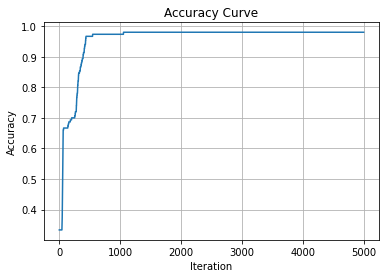

In [29]:
plt.title("Accuracy Curve")
plt.plot(accuracy_curve)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [30]:
#loss
net.loss(X,Y)

0.06732845894813307

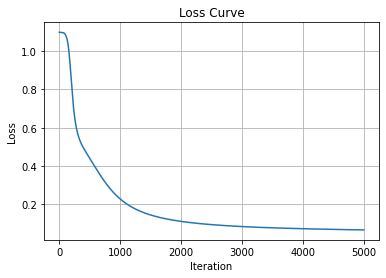

In [31]:
plt.title("Loss Curve")
plt.plot(net.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [32]:
net.W1

array([[-0.49580432,  1.50960876,  1.68297647],
       [-1.72575126,  1.70721578,  1.67990558],
       [ 2.68554912, -2.40707745, -2.55065425],
       [ 1.29464481, -2.77733414, -2.97505541]])

In [33]:
net.b1

array([-0.32130748,  1.56998569,  1.7069662 ])

In [35]:
net.W2

array([[-6.23446456,  2.57294588,  3.66050795],
       [ 3.51584765,  1.4464291 , -4.95393322],
       [ 2.83575865,  1.92071895, -4.77043751]])

In [36]:
net.b2

array([-0.20541293, -1.84314386,  2.04855679])

In [37]:
#予測結果
#学習済みの重み行列とバイアスを用いて順方向の計算を行うことで、既知のデータ・未知のデータに対する予測値を算出できます。

net.forward_propagation(X)

array([[9.89595706e-01, 1.04032334e-02, 1.06018474e-06],
       [9.88442922e-01, 1.15558849e-02, 1.19350365e-06],
       [9.89203520e-01, 1.07953750e-02, 1.10542254e-06],
       [9.87894929e-01, 1.21038133e-02, 1.25768913e-06],
       [9.89674687e-01, 1.03242615e-02, 1.05113536e-06],
       [9.89421402e-01, 1.05775183e-02, 1.08020423e-06],
       [9.89083914e-01, 1.09149663e-02, 1.11933764e-06],
       [9.89155023e-01, 1.08438659e-02, 1.11092420e-06],
       [9.87393475e-01, 1.26052076e-02, 1.31687393e-06],
       [9.88506856e-01, 1.14919584e-02, 1.18599694e-06],
       [9.89733222e-01, 1.02657334e-02, 1.04438514e-06],
       [9.88632639e-01, 1.13661891e-02, 1.17147438e-06],
       [9.88591215e-01, 1.14076084e-02, 1.17623856e-06],
       [9.89330321e-01, 1.06685877e-02, 1.09089462e-06],
       [9.90149541e-01, 9.84946224e-03, 9.96820047e-07],
       [9.90088968e-01, 9.91002866e-03, 1.00372876e-06],
       [9.89981801e-01, 1.00171832e-02, 1.01597243e-06],
       [9.89500682e-01, 1.04982